In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
%matplotlib inline

### Data Scraping

In [3]:
url = 'https://www.foodpanda.pk/city/lahore'
response = requests.get(url)

In [4]:
# 200 indicates success
response

<Response [200]>

In [5]:
b_soup = BeautifulSoup(response.text, 'html.parser')
names = []
ratings = []
ratings_count = []
delivery_fee = []
minimum_order = []
vendor_char = []

In [6]:
for a in b_soup.findAll('a', attrs={'class':'hreview-aggregate url'}):
    name=a.find('span', attrs={'class':'name fn'})
    names.append(name.text)
    rating=a.find('span', attrs={'class':'rating'})
    if rating:
        ratings.append(rating.text)
        rating_count=a.find('span', attrs={'class':'count'})
        ratings_count.append(rating_count.text)
    else:
        ratings.append(None)
        ratings_count.append(None)
    min_order=a.find('ul', attrs={'class':'extra-info mov-df-extra-info'})
    ls = min_order.text.split('\n')
    ls_ = [s for s in ls if s]
    minimum_order.append(ls_[0])
    delivery_fee.append(ls_[1])
    vendor_characteristics=a.find('li', attrs={'class':'vendor-characteristic'})
    vendor_char.append(vendor_characteristics.text)

#### creating a data frame

In [7]:
restaurants_df = pd.DataFrame()
restaurants_df["name"] = pd.Series(names)
restaurants_df["rating"] = pd.Series(ratings)
restaurants_df["rating_count"] = pd.Series(ratings_count)
restaurants_df["delivery_fee"] = pd.Series(delivery_fee)
restaurants_df["min_order"] = pd.Series(minimum_order)
restaurants_df["vendor_char"] = pd.Series(vendor_char)

In [8]:
restaurants_df

,name,rating,rating_count,delivery_fee,min_order,vendor_char
0,Samosa Kitchen,4/5,\n219\n,Free delivery,No minimum,\nRestaurant Own delivery\nPakistani\n
1,Margherito's Pizza,4/5,\n11\n,Free delivery,No minimum,\nPizza\n
2,Shawarma Time - Bhabara Market,2.2/5,\n4\n,Free delivery,No minimum,\nSuper Discount\nFast Food\n
3,Top Inn Pizza,None,None,Free delivery,No minimum,\nChicken\nFast Food\nFried Chicken\nSnacks-St...
4,#TheDeli,4.1/5,\n6\n,Free delivery,No minimum,\nfoodpanda delivery\nAmerican\n
...,...,...,...,...,...,...
251,MAA G KY PARATHY,5/5,\n1\n,Free delivery,No minimum,\nParatha\nfoodpanda delivery\nPakistani\n
252,Mr Fluffy Fluffs,None,None,Free delivery,No minimum,\nfoodpanda delivery\nDesserts\n
253,Kernel's Kitchen,3.6/5,\n3\n,Free delivery,No minimum,\nBBQ\nIce Cream\nTea\nRoll Paratha\nfoodpanda...
254,Arabic Mandi,None,None,Free delivery,No minimum,\nfoodpanda delivery\nPakistani\n


### Data Cleaning

In [9]:
restaurants_df['rating_count'] = restaurants_df['rating_count'].apply(lambda x:x if (x is None) else re.findall(r'\d+', x)[0])

In [10]:
restaurants_df['vendor_char'] = restaurants_df['vendor_char'].apply(lambda x: x.split('\n'))
restaurants_df['vendor_char'] 

0               [, Restaurant Own delivery, Pakistani, ]
1                                            [, Pizza, ]
2                        [, Super Discount, Fast Food, ]
3      [, Chicken, Fast Food, Fried Chicken, Snacks-S...
4                     [, foodpanda delivery, American, ]
                             ...                        
251         [, Paratha, foodpanda delivery, Pakistani, ]
252                   [, foodpanda delivery, Desserts, ]
253    [, BBQ, Ice Cream, Tea, Roll Paratha, foodpand...
254                  [, foodpanda delivery, Pakistani, ]
255               [, Restaurant Own delivery, Chinese, ]
Name: vendor_char, Length: 256, dtype: object

In [11]:
restaurants_df['vendor_char'] = restaurants_df['vendor_char'].apply(lambda x: [s for s in x if s])
restaurants_df['vendor_char']

0                   [Restaurant Own delivery, Pakistani]
1                                                [Pizza]
2                            [Super Discount, Fast Food]
3      [Chicken, Fast Food, Fried Chicken, Snacks-Str...
4                         [foodpanda delivery, American]
                             ...                        
251             [Paratha, foodpanda delivery, Pakistani]
252                       [foodpanda delivery, Desserts]
253    [BBQ, Ice Cream, Tea, Roll Paratha, foodpanda ...
254                      [foodpanda delivery, Pakistani]
255                   [Restaurant Own delivery, Chinese]
Name: vendor_char, Length: 256, dtype: object

In [12]:
restaurants_df['delivery_option'] = restaurants_df['vendor_char'].apply(lambda x: ''.join([s for s in x if "delivery" in s]))
restaurants_df['delivery_option']

0      Restaurant Own delivery
1                             
2                             
3           foodpanda delivery
4           foodpanda delivery
                ...           
251         foodpanda delivery
252         foodpanda delivery
253         foodpanda delivery
254         foodpanda delivery
255    Restaurant Own delivery
Name: delivery_option, Length: 256, dtype: object

In [13]:
restaurants_df['food'] = restaurants_df['vendor_char'].apply(lambda x: [s for s in x if "delivery" not in s])
restaurants_df['food']

0                                            [Pakistani]
1                                                [Pizza]
2                            [Super Discount, Fast Food]
3      [Chicken, Fast Food, Fried Chicken, Snacks-Str...
4                                             [American]
                             ...                        
251                                 [Paratha, Pakistani]
252                                           [Desserts]
253    [BBQ, Ice Cream, Tea, Roll Paratha, Beverage, ...
254                                          [Pakistani]
255                                            [Chinese]
Name: food, Length: 256, dtype: object

In [14]:
# we don't need to keep this column now
restaurants_df.drop('vendor_char', axis=1, inplace=True)

In [15]:
restaurants_df['rating'] = restaurants_df['rating'].apply(lambda x: x if x is None else x.split('/')[0])

In [16]:
restaurants_df.rename(columns={'rating': 'rating(out of 5)'},inplace=True)

In [17]:
restaurants_df

,name,rating(out of 5),rating_count,delivery_fee,min_order,delivery_option,food
0,Samosa Kitchen,4,219,Free delivery,No minimum,Restaurant Own delivery,[Pakistani]
1,Margherito's Pizza,4,11,Free delivery,No minimum,,[Pizza]
2,Shawarma Time - Bhabara Market,2.2,4,Free delivery,No minimum,,"[Super Discount, Fast Food]"
3,Top Inn Pizza,None,None,Free delivery,No minimum,foodpanda delivery,"[Chicken, Fast Food, Fried Chicken, Snacks-Str..."
4,#TheDeli,4.1,6,Free delivery,No minimum,foodpanda delivery,[American]
...,...,...,...,...,...,...,...
251,MAA G KY PARATHY,5,1,Free delivery,No minimum,foodpanda delivery,"[Paratha, Pakistani]"
252,Mr Fluffy Fluffs,None,None,Free delivery,No minimum,foodpanda delivery,[Desserts]
253,Kernel's Kitchen,3.6,3,Free delivery,No minimum,foodpanda delivery,"[BBQ, Ice Cream, Tea, Roll Paratha, Beverage, ..."
254,Arabic Mandi,None,None,Free delivery,No minimum,foodpanda delivery,[Pakistani]


In [18]:
restaurants_df.describe(include='all')

,name,rating(out of 5),rating_count,delivery_fee,min_order,delivery_option,food
count,256,165,165,256,256,256,256
unique,255,23,115,2,1,3,198
top,Tandoor Restaurant,4.1,1,Free delivery,No minimum,foodpanda delivery,[Pakistani]
freq,2,28,14,253,256,200,16


In [19]:
restaurants_df.dtypes

name                object
rating(out of 5)    object
rating_count        object
delivery_fee        object
min_order           object
delivery_option     object
food                object
dtype: object

#### changing the data type of columns with numerical data

In [20]:
restaurants_df['rating(out of 5)'] = restaurants_df['rating(out of 5)'].astype('float')

In [21]:
restaurants_df['rating_count'] = restaurants_df['rating_count'].astype('float')

In [22]:
restaurants_df.dtypes

name                 object
rating(out of 5)    float64
rating_count        float64
delivery_fee         object
min_order            object
delivery_option      object
food                 object
dtype: object

In [23]:
# now that we have float data type, the output of describe() is below
restaurants_df.describe(include='all')

,name,rating(out of 5),rating_count,delivery_fee,min_order,delivery_option,food
count,256,165.000000,165.000000,256,256,256,256
unique,255,NaN,NaN,2,1,3,198
top,Tandoor Restaurant,NaN,NaN,Free delivery,No minimum,foodpanda delivery,[Pakistani]
freq,2,NaN,NaN,253,256,200,16
mean,NaN,3.850909,293.418182,NaN,NaN,NaN,NaN
std,NaN,0.712828,607.464634,NaN,NaN,NaN,NaN
min,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,3.800000,9.000000,NaN,NaN,NaN,NaN
50%,NaN,4.000000,48.000000,NaN,NaN,NaN,NaN
75%,NaN,4.200000,214.000000,NaN,NaN,NaN,NaN


### Saving Data Frame as CSV File

In [24]:
restaurants_df.to_csv('food_panda_lhr_data.csv',sep="\t")

### Analyzing Data

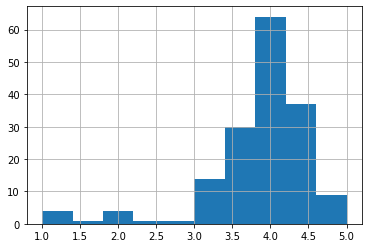

In [25]:
restaurants_df['rating(out of 5)'].hist()

#### list of unique items in 'food' column

In [26]:
set([item for list in restaurants_df['food'].values for item in list])

{'Afghani',
 'Afro-Portuguese',
 'American',
 'Arabic',
 'Asian',
 'BBQ',
 'Beverage',
 'Broast',
 'Burgers',
 'Cakes & Bakery',
 'Chicken',
 'Chinese',
 'Coffee',
 'Crepes',
 'Cupcakes',
 'Curry',
 'Desserts',
 'European',
 'Fast Food',
 'Finger Foods',
 'Fish',
 'Fried Chicken',
 'Halwa',
 'Healthy',
 'Hot dogs',
 'Ice Cream',
 'Ice Cream Shakes',
 'International',
 'Italian',
 'Japanese',
 'Juices',
 'Karahi',
 'Lassi',
 'Lebanese',
 'Meat',
 'Mexican',
 'Middle Eastern',
 'Namkeen',
 'Noodles',
 'Pakistani',
 'Pakora',
 'Pancakes',
 'Paratha',
 'Pasta',
 'Pizza',
 'Prawns',
 'Rice',
 'Roll Paratha',
 'Salad',
 'Sandwiches',
 'Seafood',
 'Singaporean',
 'Smoothie Bowl',
 'Snacks-Street Food',
 'Soup',
 'Spicy',
 'Steaks',
 'Super Discount',
 'Sweets',
 'Tacos',
 'Tandoor',
 'Tea',
 'Thai',
 'Thin Crust Pizza',
 'Turkish',
 'Vegetarian',
 'Vietnamese',
 'Waffle',
 'Western',
 'Wraps'}

#### restaurants which serve certain type of food

In [29]:
food_type = ['Pakistani']
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(restaurants_df[pd.DataFrame(restaurants_df.food.tolist()).isin(food_type).any(1)]['name'])

0                                      Samosa Kitchen
8                         Balochi Sajji by Bundu Khan
11                               Salt N Pepper lahore
12                                    Khala's Kitchen
13                                            Basanti
14                           Lahori Biryani - Gulberg
16                                       Sultan Basha
17                                   Karachi Red Rock
19            Karachi Master Foods Paratha Roll & BBQ
20                        Red Pepper Restaurant & BBQ
24                  Karachi Golden BBQ & Paratha Roll
25                                     Kings & Queens
28                                Paradise Restaurant
34                                     Downtown China
42                                    Lebanese Corner
43                                     Five Star Cafe
47                                           The Spot
62                                        Cafe Anokhi
63                          

#### minimum and maximum value of rating for each type of delivery option

In [30]:
restaurants_df.groupby('delivery_option')['rating(out of 5)'].agg([('Min' , 'min'), ('Max', 'max')])

,Min,Max
delivery_option,,
,2.2,4.7
Restaurant Own delivery,3.3,5.0
foodpanda delivery,1.0,5.0
